# Topic Model
## Read data

In [1]:
import pandas as pd
import numpy as np

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/processed_data.csv')

In [3]:
df.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,text
0,27673,2053,24h,i went on a successful date with someone i fel...,i went on a successful date with someone i fel...,True,1,NaN,affection,successful date sympathy connection
1,27674,2,24h,i was happy when my son got 90% marks in his e...,i was happy when my son got 90% marks in his e...,True,1,NaN,affection,son mark examination
2,27675,1936,24h,i went to the gym this morning and did yoga.,i went to the gym this morning and did yoga.,True,1,NaN,exercise,gym morning yoga
3,27676,206,24h,we had a serious talk with some friends of our...,we had a serious talk with some friends of our...,True,2,bonding,bonding,serious talk friend flaky lately understood go...
4,27677,6227,24h,i went with grandchildren to butterfly display...,i went with grandchildren to butterfly display...,True,1,NaN,affection,grandchild butterfly display crohn conservatory


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 10 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
text                     100522 non-null object
dtypes: bool(1), int64(3), object(6)
memory usage: 7.0+ MB


## Vectorization

### CountVectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df = df[df['text'].isna() == False]

In [5]:
%%capture
df['text'].dropna(axis=0, how='any', inplace=True)

In [6]:
bow_transformer = CountVectorizer(analyzer='word').fit(df['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

24652


In [10]:
df_bow = bow_transformer.transform(df['text'])

In [11]:
print('Shape of Sparse Matrix: ', df_bow.shape)
print('Amount of Non-Zero occurences: ', df_bow.nnz)

Shape of Sparse Matrix:  (100522, 24652)
Amount of Non-Zero occurences:  716074


In [12]:
# check text sparsicity
sparsity = (100.0 * df_bow.nnz / (df_bow.shape[0] * df_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## LDA

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

### Fit LDA model with 10 topics

In [89]:
lda = LatentDirichletAllocation(n_components=10, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=1)

In [90]:
%%time
lda.fit(df_bow)

CPU times: user 16min 45s, sys: 8.67 s, total: 16min 53s
Wall time: 18min


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [91]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [92]:
topic_keywords = show_topics(vectorizer=bow_transformer, lda_model=lda, n_words=10)

In [93]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,daughter,job,watched,mother,movie,surprise,card,want,said,lost
Topic 1,life,dog,make,thing,feel,one,car,get,would,much
Topic 2,family,birthday,husband,morning,work,told,mom,money,party,class
Topic 3,dinner,night,good,girlfriend,food,wife,ate,watching,nice,show
Topic 4,found,getting,finished,finally,gift,free,project,brother,completed,helped
Topic 5,time,first,sister,great,baby,spend,early,park,new,phone
Topic 6,ive,wanted,cat,shopping,summer,date,weather,purchased,great,actually
Topic 7,new,home,work,time,bought,friend,long,see,house,visit
Topic 8,received,old,school,work,parent,vacation,working,song,state,goal
Topic 9,friend,game,new,best,started,lunch,weekend,event,son,played


- Some topics are similar to each other. Try to grid search the best number of topics.

### Grid search the best number of topics

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
search_params = {'n_components': [5, 6, 7, 8, 9]}
lda = LatentDirichletAllocation(max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [96]:
model = GridSearchCV(lda, param_grid=search_params, cv=3)

In [97]:
%%time
model.fit(df_bow)

CPU times: user 36min 27s, sys: 19.8 s, total: 36min 46s
Wall time: 38min 42s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                 

In [98]:
# Best Model
best_lda_model = model.best_estimator_

In [99]:
print("Best Model's Params: ", model.best_params_)
print('\n')
print("Best Log Likelihood Score: ", model.best_score_)
print('\n')
print("Model Perplexity: ", best_lda_model.perplexity(df_bow))

Best Model's Params:  {'n_components': 5}


Best Log Likelihood Score:  -2066556.0373598626


Model Perplexity:  2413.4145621385214


In [100]:
# Get Log Likelihoods from Grid Search Output
n_topics = [5, 6, 7, 8, 9]
log_likelihoods = model.cv_results_['mean_test_score']

Text(0, 0.5, 'Log Likelihood Scores')

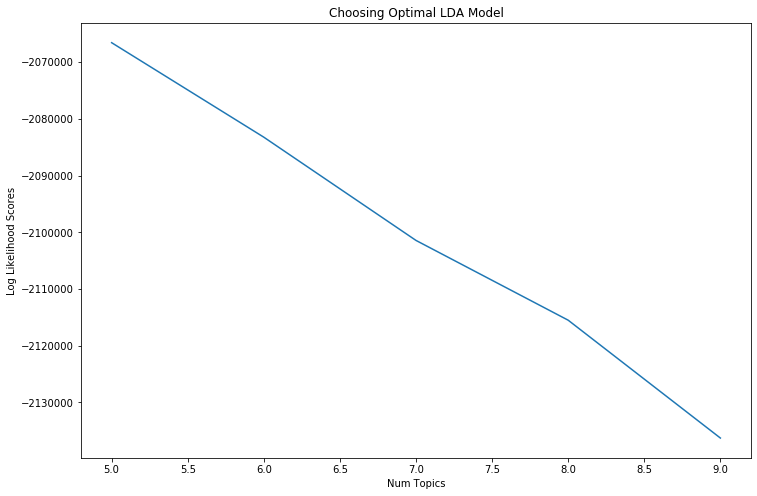

In [101]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihoods)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")

### Topic words for best model

In [170]:
topic_keywords = show_topics(vectorizer=bow_transformer, lda_model=best_lda_model, n_words=10)

In [171]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 1,baby,hit,raise,exam,want,taking,college,extra,passed,several
Topic 2,birthday,party,cat,temple,breakfast,friend,celebrated,ice,cream,family
Topic 3,new,work,job,time,get,car,bought,house,home,event
Topic 4,dinner,lunch,wife,ate,friend,family,good,food,shopping,spent
Topic 5,friend,game,time,movie,dog,old,watched,long,weekend,played


- Topic 1 has words expressing the feeling of a monment, so I define it as enjoy the moment.              
- Topic 2 involves words like birthday, party and famliy which can be concluded as affection.                     
- Topic 3 turns out to be things concerning achievement.            
- Topic 4 is about friend and family and classified as bonding.         
- Topic 5 seems to be related to the leisure.     

### Visualize the LDA model

In [172]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(best_lda_model, df_bow, bow_transformer)

/Users/wangxinquan/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.202385 -0.045891       1        1  36.795137
3      0.135301  0.044977       2        1  20.402656
4      0.118216  0.018883       3        1  20.192159
0     -0.221727 -0.260138       4        1  11.439556
1     -0.234175  0.242168       5        1  11.170492, topic_info=      Category         Freq      Term        Total  loglift  logprob
2167   Default  2522.000000  birthday  2522.000000  30.0000  30.0000
5910   Default  3124.000000    dinner  3124.000000  29.0000  29.0000
8694   Default  2435.000000      game  2435.000000  28.0000  28.0000
8450   Default  6820.000000    friend  6820.000000  27.0000  27.0000
14114  Default  2118.000000     movie  2118.000000  26.0000  26.0000
...        ...          ...       ...          ...      ...      ...
12381   Topic5   503.100000      life  1751.010440   0.9447  -5.1219
7595    Topic5   569.053334    family  3223.403568   0.4577  -4.9987
21275   Topic5   389.529161  surprise   867.164479   1.3916  -5.3778
3978    Topic5   314.937490     close   502.282607   1.7251  -5.5903
2023    Topic5   300.087170      best  1497.685065   0.5843  -5.6386

[244 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
89         1  0.002199  accepted
89         2  0.002199  accepted
89         3  0.002199  accepted
89         4  0.994044  accepted
89         5  0.002199  accepted
...      ...       ...       ...
24348      1  0.951700     would
24348      2  0.046293     would
24348      3  0.001077     would
24348      4  0.001077     would
24348      5  0.001077     would

[990 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

Although there's overlap between the blobs, this topic model is fairly good to identify different topics. And topic enjoy the moment and affection are separated distinctly from the other topics.

### Get dominant topic for each document

In [179]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(df_bow)

# column names
topicnames = ["Topic" + str(i) for i in range(5)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [180]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.04,0.04,0.04,0.04,0.84,4
Doc1,0.05,0.05,0.05,0.05,0.80,4
Doc2,0.05,0.05,0.80,0.05,0.05,2
Doc3,0.55,0.02,0.02,0.39,0.02,0
Doc4,0.87,0.03,0.03,0.03,0.03,0


In [181]:
mapping = {0:'enjoy_the_moment', 1:'affection', 2:'achievement', 3:'bonding', 4:'leisure'}

In [182]:
df_document_topic['dominant_topic'] = df_document_topic['dominant_topic'].map(mapping)

In [183]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.04,0.04,0.04,0.04,0.84,leisure
Doc1,0.05,0.05,0.05,0.05,0.80,leisure
Doc2,0.05,0.05,0.80,0.05,0.05,achievement
Doc3,0.55,0.02,0.02,0.39,0.02,enjoy_the_moment
Doc4,0.87,0.03,0.03,0.03,0.03,enjoy_the_moment


In [184]:
df.reset_index(drop=True, inplace=True)
df_document_topic.reset_index(drop=True, inplace=True)

In [185]:
df = pd.concat([df, df_document_topic['dominant_topic']], axis=1)

In [186]:
df = df.drop(columns='predicted_category')

In [187]:
df = df.rename(columns={'dominant_topic': 'Topic'})

In [188]:
df.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,text,Topic
0,27673,2053,24h,i went on a successful date with someone i fel...,i went on a successful date with someone i fel...,True,1,NaN,successful date sympathy connection,leisure
1,27674,2,24h,i was happy when my son got 90% marks in his e...,i was happy when my son got 90% marks in his e...,True,1,NaN,son mark examination,leisure
2,27675,1936,24h,i went to the gym this morning and did yoga.,i went to the gym this morning and did yoga.,True,1,NaN,gym morning yoga,achievement
3,27676,206,24h,we had a serious talk with some friends of our...,we had a serious talk with some friends of our...,True,2,bonding,serious talk friend flaky lately understood go...,enjoy_the_moment
4,27677,6227,24h,i went with grandchildren to butterfly display...,i went with grandchildren to butterfly display...,True,1,NaN,grandchild butterfly display crohn conservatory,enjoy_the_moment


### Topics distribution across documents

In [189]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,bonding,30637
1,affection,25026
2,enjoy_the_moment,18532
3,achievement,16979
4,leisure,9348


## Save data with topic 

In [ ]:
df.to_csv(r'./data/topic_data.csv', index=False)